<a href="https://colab.research.google.com/github/thichxemsex/Github_clone_demo/blob/main/Softmax_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git remote add origin https://github.com/thichxemsex/streamlit_demo.git
!git branch -M main
!git push -u origin main

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
import plotly.express as px
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil

In [ ]:
#https://drive.google.com/file/d/1IG6KoZP3BOB9fES3eHSUhG5LeWQXUo4-/view?usp=sharing
%%shell
pip -q install --upgrade --no-cache-dir gdown
gdown -q 1IG6KoZP3BOB9fES3eHSUhG5LeWQXUo4-
echo 'download: done => file: Data.zip'
rm -rf ./data/
unzip -q Data.zip
echo 'Data files in: data/'


download: done => file: Data.zip
replace Data/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Data files in: data/


In [ ]:
class_names = list(filter(lambda f: os.path.isdir(os.path.join('/content/Data', f)), os.listdir('/content/Data')))
class_names = sorted(class_names)
num_classes = len(class_names)
print(f"Class Names: \n{class_names}")
print(f"Total Number of Classes : {num_classes}")

Class Names: 
['Cat', 'Crocodile', 'Frog', 'Snake', 'Turtle']
Total Number of Classes : 5


In [ ]:
class_dis = [len(os.listdir('/content/Data' + f"/{name}")) for name in class_names]
lk_dis = dict(zip(class_names, class_dis))
print(f"Class Distribution : \n{lk_dis}")

fig = px.pie(names=class_names, values=class_dis, width=600)
fig.update_layout({"title":{'text':"Class Distribution","x":0.5}})
fig.show()

Class Distribution : 
{'Cat': 1200, 'Crocodile': 962, 'Frog': 811, 'Snake': 878, 'Turtle': 882}


In [ ]:

# Đường dẫn đến thư mục chứa dữ liệu
data_dir = "/content/Data"

# Tạo thư mục cho tập huấn luyện và kiểm thử
train_dir = '/content/train'
val_dir = '/content/val'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Lấy danh sách tất cả các thư mục con (nhãn)
labels = os.listdir(data_dir)

# Chia dữ liệu và di chuyển vào thư mục tương ứng
for label in labels:
    label_path = os.path.join(data_dir, label)
    train_label_dir = os.path.join(train_dir, label)
    val_label_dir = os.path.join(val_dir, label)

    os.makedirs(train_label_dir, exist_ok=True)
    os.makedirs(val_label_dir, exist_ok=True)

    # Lấy danh sách các hình ảnh
    images = os.listdir(label_path)

    # Chia dữ liệu thành train set và val set
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Di chuyển hình ảnh vào thư mục tương ứng
    for img in train_images:
        src = os.path.join(label_path, img)
        dst = os.path.join(train_label_dir, img)
        shutil.copyfile(src, dst)

    for img in val_images:
        src = os.path.join(label_path, img)
        dst = os.path.join(val_label_dir, img)
        shutil.copyfile(src, dst)

In [ ]:
# Kích thước ảnh và batch size
image_size = (224, 224)
batch_size = 32

# Tạo tập dữ liệu từ thư mục train và val
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=image_size,
    batch_size=batch_size
)

Found 3784 files belonging to 5 classes.
Found 949 files belonging to 5 classes.


In [ ]:
# Lấy tên lớp
class_names = train_ds.class_names
print("Class names:", class_names)

# Chuẩn hóa dữ liệu
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))

# Tăng tốc độ load dữ liệu
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Tăng cường dữ liệu
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])


Class names: ['Cat', 'Crocodile', 'Frog', 'Snake', 'Turtle']


In [ ]:
# Xây dựng mô hình
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    data_augmentation,  # Tăng cường dữ liệu
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout để giảm overfitting
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

In [ ]:
# Compile mô hình
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callback để giảm learning rate khi val_accuracy không cải thiện
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Huấn luyện mô hình
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[reduce_lr]
)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 507s 4s/step - accuracy: 0.2718 - loss: 1.7978 - val_accuracy: 0.4162 - val_loss: 1.3820 - learning_rate: 0.0010
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 537s 4s/step - accuracy: 0.3615 - loss: 1.4488 - val_accuracy: 0.4647 - val_loss: 1.3575 - learning_rate: 0.0010
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 480s 4s/step - accuracy: 0.4311 - loss: 1.3487 - val_accuracy: 0.5153 - val_loss: 1.2134 - learning_rate: 0.0010
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 487s 4s/step - accuracy: 0.4673 - loss: 1.2602 - val_accuracy: 0.5595 - val_loss: 1.0836 - learning_rate: 0.0010
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 475s 4s/step - accuracy: 0.4855 - loss: 1.2110 - val_accuracy: 0.5364 - val_loss: 1.0909 - learning_rate: 0.0010
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 501s 4s/step - accuracy: 0.5482 - loss: 1.1481 - val_accuracy: 0.6207 - val_loss: 0.9819 - learning_rate: 0.0010
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 502s 4s/step - accuracy: 0.5367 - loss: 1.

In [ ]:
# Hiển thị lịch sử huấn luyện
print("Training history:", history.history)

# Hiển thị phân phối lớp trong tập huấn luyện
class_distribution = {class_name: 0 for class_name in class_names}
for images, labels in train_ds.unbatch():
    class_distribution[class_names[labels.numpy()]] += 1

print("Class distribution:", class_distribution)

Training history: {'accuracy': [0.3187103569507599, 0.3866279125213623, 0.4460887908935547, 0.4949788451194763, 0.5084566473960876, 0.5496828556060791, 0.5425475835800171, 0.5544397234916687, 0.5658034086227417, 0.5644820332527161, 0.586152195930481, 0.5769027471542358, 0.6001585721969604, 0.6146934628486633, 0.6265856027603149, 0.6522198915481567, 0.6413847804069519, 0.665433406829834, 0.6720401644706726, 0.6659619212150574], 'loss': [1.577472448348999, 1.4052925109863281, 1.3290419578552246, 1.2271467447280884, 1.2002235651016235, 1.1410462856292725, 1.123995304107666, 1.1073510646820068, 1.108675241470337, 1.078360915184021, 1.042977213859558, 1.0442951917648315, 1.029675841331482, 0.9654932618141174, 0.9411081671714783, 0.9073526263237, 0.8975487947463989, 0.8773590326309204, 0.8393700122833252, 0.8421216607093811], 'val_accuracy': [0.4162276089191437, 0.4646996855735779, 0.515279233455658, 0.559536337852478, 0.5363540649414062, 0.6206533312797546, 0.5542676448822021, 0.63013696670

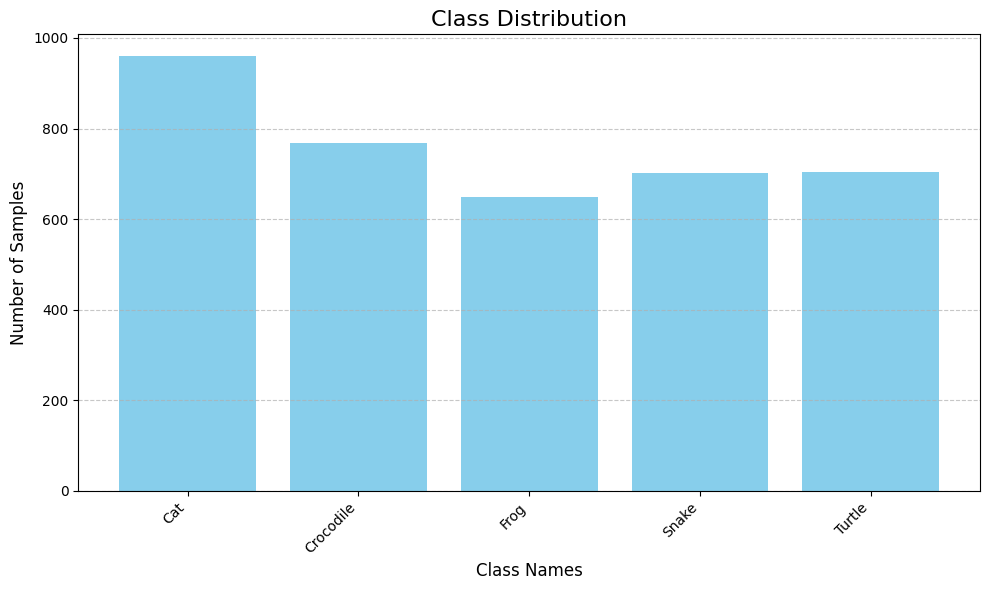

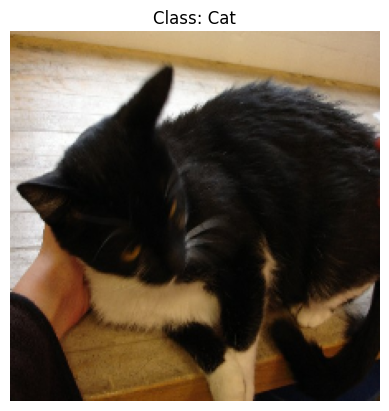

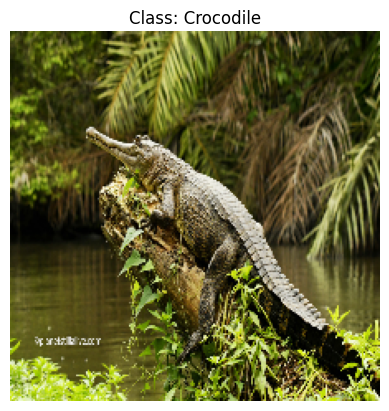

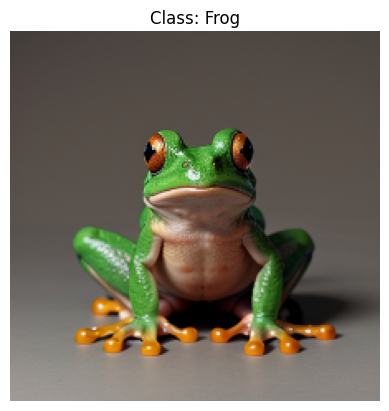

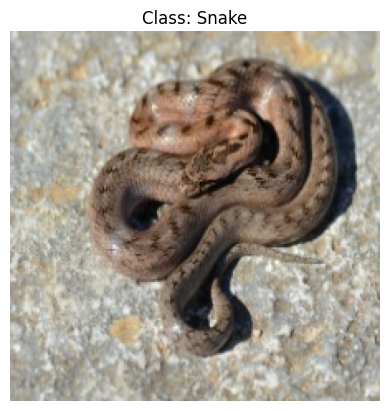

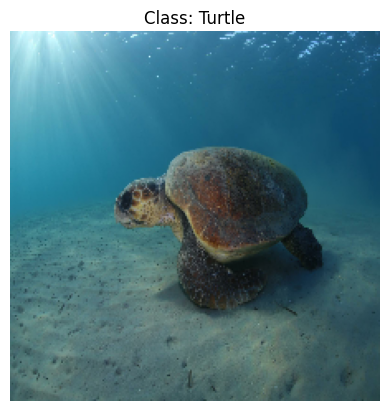

In [ ]:
# Trực quan hóa dữ liệu bằng biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.title("Class Distribution", fontsize=16)
plt.xlabel("Class Names", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Xoay nhãn lớp nếu cần
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Trực quan hóa dữ liệu mẫu cho từng lớp
for class_name in class_names:
    for images, labels in train_ds.unbatch():
        if class_names[labels.numpy()] == class_name:
            plt.figure()
            plt.imshow(images.numpy())
            plt.title(f"Class: {class_name}")
            plt.axis("off")
            plt.show()
            break